# Reinforcement Learning for Manipulation of Ferroelectric Domain Walls

By B. Smith (UTk) and R. Vasudevan (CNMS/ORNL)

In [2]:
%%shell

gdown -q -O content_f.zip https://www.dropbox.com/s/4jdy61somsggtgf/RL%20Lecture.zip?dl=1
unzip content_f.zip
mv "RL Lecture/agent.py" "agent.py"
mv "RL Lecture/env.py" "env.py"

Archive:  content_f.zip
   creating: RL Lecture/
  inflating: __MACOSX/._RL Lecture   
  inflating: RL Lecture/surrogate_model.h5  
  inflating: __MACOSX/RL Lecture/._surrogate_model.h5  
  inflating: RL Lecture/.DS_Store    
  inflating: __MACOSX/RL Lecture/._.DS_Store  
  inflating: RL Lecture/env.py       
  inflating: __MACOSX/RL Lecture/._env.py  
  inflating: RL Lecture/actor_weights.h5  
  inflating: __MACOSX/RL Lecture/._actor_weights.h5  
  inflating: RL Lecture/agent.py     
  inflating: __MACOSX/RL Lecture/._agent.py  
  inflating: RL Lecture/RL_DomainWalls.ipynb  
  inflating: __MACOSX/RL Lecture/._RL_DomainWalls.ipynb  


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

import sys
from agent import NeuralNet_A2C
from env import *
%matplotlib inline

# Initialize Environment and Agent

In [4]:
#Load trained agent and environments
model_file = r'RL Lecture/surrogate_model.h5'
actor_file = 'RL Lecture/actor_weights.h5'
INS_Env = WallEnv(model_file = model_file)

policy = NeuralNet_A2C(input_dim=(128,1), dim_actions=3, actor_lr = 0.0001, critic_lr = 0.0002)
policy.actor.load_weights(actor_file)

# Explore the domain wall environment

Here let us see what happens when we apply random actions in the environment

The actions are passed to the environment as a 3 dimensional vector
- The first value is the location (normalized) to apply the voltage
- The second value is the magnitude of the bias (amplitude)
- The third value is the magnitude of the pulse width


In [5]:
final_states, final_rewards = [], []
num_trials = 5
initial_states = []
for _ in range(num_trials):
    actions_history, state_history, reward_history = [], [], []

    state,_ = INS_Env.reset()
    initial_states.append(state)
    reward_total = 0
    done = False

    while not done:

        actions_output, _ = policy(state[None,:, None])

        actions_output = tf.reshape(actions_output[0, :], (-1, 2))

        # Sample the policy to get the action
        output_actions = np.array([np.random.uniform(0.1,0.9), np.random.uniform(0.1, 0.9), np.random.uniform(0.1, 0.9)])
        next_state, reward, done, _ = INS_Env.step(output_actions)

        actual_reward = reward
        reward_total += actual_reward

        next_state = np.squeeze(next_state)

        # Save results
        actions_history.append(output_actions)


        state_history.append(state.flatten())
        reward_history.append(reward)

        # First up, the actor network
        state = next_state.flatten()

    final_states.append(state)
    final_rewards.append(reward)

<ipython-input-15-36fbe7bfaaa4>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(state_history))


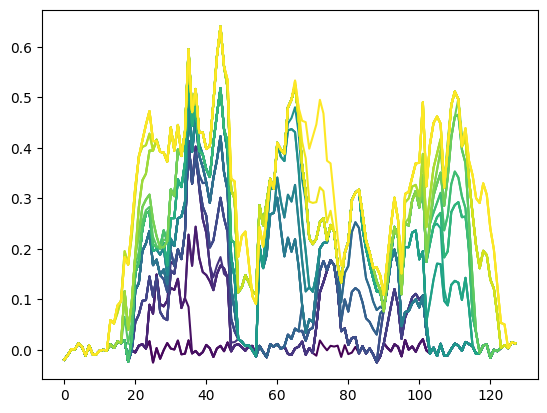

In [15]:
#Let's print out the states
plt.figure()
colors = plt.cm.get_cmap('viridis', len(state_history))
for ind,state_p in enumerate(state_history):
  plt.plot(state_p, color = colors(ind))


In [ ]:
#Can you create a heatmap of the area under the domain wall, as a function of changing bias amplitudes and pulse widths?
# HINT: you can use np.trapz to calculate areas.



# Simulate policies in domain wall environment

Here we will use the trained agent, to see how it performs.

In [ ]:
final_states, final_rewards = [], []
num_trials = 10
initial_states = []
for _ in range(num_trials):
    actions_history, state_history, reward_history = [], [], []

    state,_ = INS_Env.reset()
    initial_states.append(state)
    reward_total = 0
    done = False

    while not done:

        actions_output, _ = policy(state[None,:, None])

        actions_output = tf.reshape(actions_output[0, :], (-1, 2))

        # Sample the policy to get the action
        output_action = tfp.distributions.MultivariateNormalDiag(
            tf.nn.softplus(actions_output[:, 0]), tf.nn.softplus(actions_output[:, 1])).sample(1)

        output_actions = np.squeeze(tf.clip_by_value(output_action, 0.1, 0.9).numpy())
        output_actions[1] = (output_actions[1]*2)-1           #need to shift from 0-1 to -1-1
        # Take the selected action in the environment
        next_state, reward, done, _ = INS_Env.step(output_actions)

        actual_reward = reward
        reward_total += actual_reward

        next_state = np.squeeze(next_state)

        # Save results
        actions_history.append(output_actions)

        #actions_history.append(output_action.numpy()[0])
        state_history.append(state.flatten())
        reward_history.append(reward)

        # First up, the actor network
        state = next_state.flatten()

    final_states.append(state)
    final_rewards.append(reward)

Label actions for plotting

In [ ]:
positions = []
for i in range(len(actions_history)):
    pos=actions_history[:][i][0]
    pos=pos*128
    positions.append(pos)

colors = []
for i in range(50):
    c = i
    colors.append(c)

colors = np.array(colors)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, 'Voltage (V)')

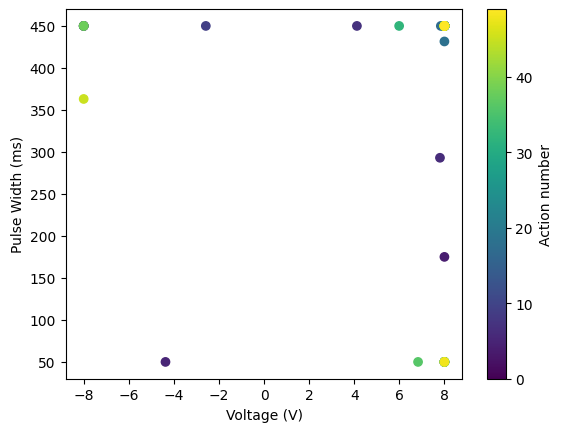

In [ ]:
v_ = []
pw_ = []
for i in range(len(actions_history)):
    v = actions_history[:][i][1]*10
    p = actions_history[:][i][2]*500
    pw_.append(p)
    v_.append(v)

plt.scatter(v_,pw_,c=colors, cmap='viridis')
plt.colorbar(label='Action number')

plt.ylabel("Pulse Width (ms)")
plt.xlabel("Voltage (V)")

Plot example of final domain wall structure, ideal wall, and location of biases selected by the trained RL policy

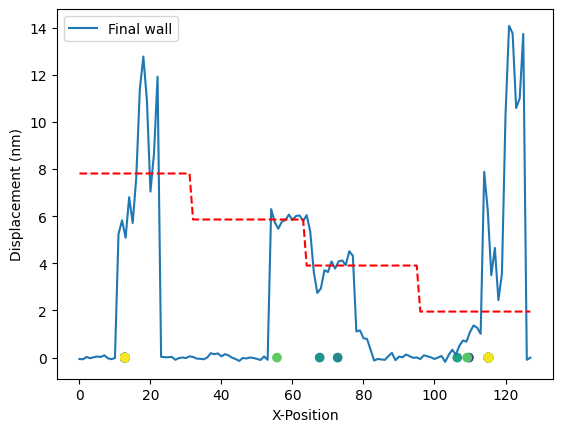

In [ ]:
plt.figure()
plt.plot(np.array(final_states).T[:,-1]*7.8125, label='Final wall')
plt.scatter(positions,np.zeros(50), c=colors, cmap='viridis')
plt.plot(INS_Env.desired_wall*7.8125, 'r--')
plt.ylabel("Displacement (nm)")
plt.xlabel("X-Position")
#plt.plot(initial_states[-1]*7.8125, label="Inital wall")
plt.legend()

In [16]:
## As you can see, the agent is not perfect! Still need more training...

# Appendix: Train the Agent

Below is the code block for training the agent. It is time consuming! This is best done with a scalable computing platform where you have accumulate transitions quickly to make each update to the agent more meaningful. It is difficult to do on Colab for anything but the simplest examples.

In [17]:
# Configuration parameters for the whole setup
gamma = 0.99  # Discount factor for rewards
lambda_val = 0.97 #GAE lambda parameter
max_steps_per_episode = 20 #number of steps per episode
total_episodes = 500 #number of episodes for training

#Set the learning rates for the optimizers for both the actor and the critic
#In general try to keep the critic updated more than the actor.

policy.actor.lr = 0.005
policy.critic.lr = 0.007

In [ ]:

env = WallEnv(model_file = model_file,reward_freq = 'all')
training_history = []

for episode in range(total_episodes):

  actions_history, state_history, reward_history, done_history = [],[],[],[]
  state,_ = env.reset()
  episode_reward = 0
  for timestep in range(max_steps_per_episode+1):
      #Run the state through the policy to get the action distribution
      actions_output, _ = policy(state[None,:, None])
      actions_output = tf.reshape(actions_output[0, :], (-1, 2))

      # Sample the policy to get the action
      output_action = tfp.distributions.MultivariateNormalDiag(
          actions_output[:, 0], actions_output[:, 1]).sample(1)

      actions_history.append(output_action)

      #Clip the action to conform to the environment requirements
      output_actions = np.squeeze(tf.clip_by_value(output_action, 0.1, 0.9).numpy())
      output_actions[1] = (output_actions[1]*2)-1           #need to shift from 0-1 to -1-1

      # Take the selected action in the environment
      next_state, reward, done, _ = env.step(output_actions)

      #Now store the data in the trajectory - the next state, the reward, and whether we are done
      state_history.append(next_state)
      reward_history.append(reward)
      done_history.append(np.array(0.0, dtype=np.float32) if done else np.array(1.0, dtype=np.float32))

      next_state = np.squeeze(next_state)
      state = next_state.flatten()
      episode_reward += reward

  print("Episode {} Reward:{}".format(episode, episode_reward))

  #Now we need to calculate the discounted rewards
  state_history_tf = tf.stack(state_history)
  done_history_tf = tf.stack(done_history)
  reward_history_tf = tf.stack(reward_history)
  actions_history_tf = tf.stack(actions_history)

  #Get the estimates for the state values from the policy for GAE
  _, old_state_values = policy(state_history_tf)
  _, new_state_values = policy(state_history_tf[1:])

  #calculate GAE
  advantage_estimate,value_target = generalized_advantage_estimate(gamma=gamma, lamda=lambda_val,
  value_old_state=old_state_values, value_new_state=new_state_values,
  reward=reward_history_tf, done=done_history_tf)

  #Code below is sometimes useful for normalizing
  #advantage_estimate = (advantage_estimate - tf.math.reduce_mean(advantage_estimate)) / tf.math.maximum(tf.math.reduce_std(advantage_estimate), tf.constant(1.0E-6))

  #Policy gradient
  dim_actions = policy.dim_actions
  with tf.GradientTape() as tape:
      # Calculate the policy gradient
      actions_mean_tt = tf.reshape(policy.actor(state_history_tf), (-1, dim_actions, 2))
      lognorm_dist = tfp.distributions.MultivariateNormalDiag(
          tf.reshape(actions_mean_tt, (done_history_tf.shape[0], dim_actions, 2))[:, :, 0],
          tf.reshape(actions_mean_tt, (done_history_tf.shape[0], dim_actions, 2))[:, :, 1]).log_prob(
          tf.reshape(actions_history_tf,(done_history_tf.shape[0],dim_actions)))

      actor_loss = -tf.reduce_mean(lognorm_dist * advantage_estimate)  # gradient of objective function
      gradients = tape.gradient(actor_loss, policy.actor.trainable_variables)
  policy.actor.optimizer.apply_gradients(zip(gradients, policy.actor.trainable_variables))

  # Critic loss
  with tf.GradientTape() as tape:
      _, state_values = policy(state_history_tf)
      state_values = state_values[:,0] * done_history_tf
      critic_loss = tf.reduce_mean((np.squeeze(np.array(value_target)) - state_values) ** 2)  # TD_error
      valueGradient = tape.gradient(critic_loss, policy.critic.trainable_variables)

  policy.critic.optimizer.apply_gradients(zip(valueGradient, policy.critic.trainable_variables))

  training_history.append([actor_loss, critic_loss, episode_reward])


Episode 0 Reward:-8.047510574405841
Episode 1 Reward:-9.699323036929108
Episode 2 Reward:-8.797066629710965
Episode 3 Reward:-8.341176500123916
Episode 4 Reward:-8.459593890668764
Episode 5 Reward:-9.044298172096887
Episode 6 Reward:-8.423289298420283
Episode 7 Reward:-9.684652944198747


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


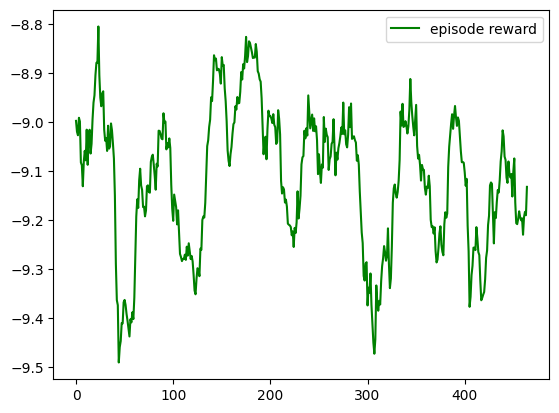

In [ ]:
#Print output of the training
training_history = np.array(training_history)
smooth_window_size = 21
plt.figure()
plt.plot(smooth_window(training_history[15:,2],smooth_window_size), 'g-', label = 'episode reward', )
plt.legend(loc='best')

In [ ]:
#Let's run the trained model and get some final state plots
final_states, final_rewards = [], []
num_trials = 10
initial_states = []
for _ in range(num_trials):
    actions_history, state_history, reward_history = [], [], []

    state,_ = INS_Env.reset()
    initial_states.append(state)
    reward_total = 0
    done = False

    while not done:

        actions_output, _ = policy(state[None,:, None])

        actions_output = tf.reshape(actions_output[0, :], (-1, 2))

        # Sample the policy to get the action
        output_action = tfp.distributions.MultivariateNormalDiag(
            tf.nn.softplus(actions_output[:, 0]), tf.nn.softplus(actions_output[:, 1])).sample(1)

        output_actions = np.squeeze(tf.clip_by_value(output_action, 0.1, 0.9).numpy())
        output_actions[1] = (output_actions[1]*2)-1           #need to shift from 0-1 to -1-1
        # Take the selected action in the environment
        next_state, reward, done, _ = INS_Env.step(output_actions)

        actual_reward = reward
        reward_total += actual_reward

        next_state = np.squeeze(next_state)

        # Save results
        actions_history.append(output_actions)

        #actions_history.append(output_action.numpy()[0])
        state_history.append(state.flatten())
        reward_history.append(reward)

        # First up, the actor network
        state = next_state.flatten()

    final_states.append(state)
    final_rewards.append(reward)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


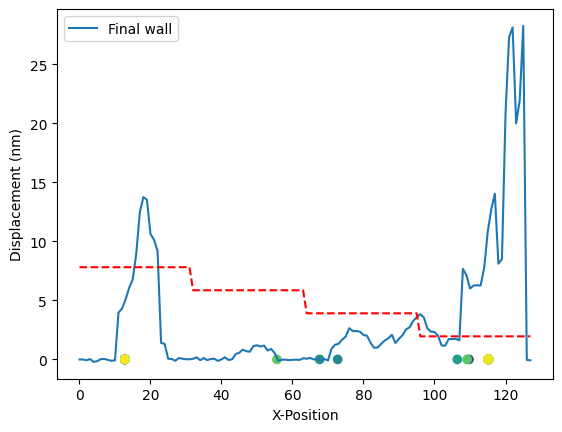

In [ ]:
plt.figure()
plt.plot(np.array(final_states).T[:,-1]*7.8125, label='Final wall')
plt.scatter(positions,np.zeros(50), c=colors, cmap='viridis')
plt.plot(INS_Env.desired_wall*7.8125, 'r--')
plt.ylabel("Displacement (nm)")
plt.xlabel("X-Position")
#plt.plot(initial_states[-1]*7.8125, label="Inital wall")
plt.legend()